In [1]:
import numpy as np
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)
import pandas as pd
pd.options.display.float_format = "{:.4f}".format
from scipy.stats import norm
from scipy.optimize import bisect, brentq
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# Problem 1

#### (a)

$$\begin{aligned}
    dr_t &= \alpha(r_t,t)dt+\beta(r_t,t)dW_t \\
    dC(r_t,t) &= \frac{\partial C}{\partial r_t} dr_t + \frac{\partial C}{\partial t} dt + \frac{1}{2} \frac{\partial^2 C}{\partial r_t^2} dr_t^2 \\
        &= \frac{\partial C}{\partial r_t} \big(\alpha(r_t,t)dt+\beta(r_t,t)dW_t\big) + \frac{\partial C}{\partial t} dt + \frac{1}{2} \frac{\partial^2 C}{\partial r_t^2} \big(\alpha(r_t,t)dt+\beta(r_t,t)dW_t\big)^2 \\
        &= \frac{\partial C}{\partial r_t} \big(\alpha(r_t,t)dt+\beta(r_t,t)dW_t\big) + \frac{\partial C}{\partial t} dt + \frac{1}{2} \frac{\partial^2 C}{\partial r_t^2} \big(\beta(r_t,t)^2dt\big) \\
        &= \bigg(\frac{\partial C}{\partial r_t} \alpha(r_t,t) + \frac{\partial C}{\partial t} + \frac{1}{2} \frac{\partial^2 C}{\partial r_t^2} \beta(r_t,t)^2\bigg) dt + \frac{\partial C}{\partial r_t} \beta(r_t,t)dW_t \\
    rC &= \frac{\partial C}{\partial r_t} \alpha(r_t,t) + \frac{\partial C}{\partial t} + \frac{1}{2} \frac{\partial^2 C}{\partial r_t^2} \beta(r_t,t)^2 \\
        &= \frac{\partial C}{\partial r_t} \kappa(\theta-r_t) + \frac{\partial C}{\partial t} + \frac{\sigma^2}{2} \frac{\partial^2 C}{\partial r_t^2}
\end{aligned}$$

In [2]:
class Dynamics:
    pass

In [3]:
hw3dynamics=Dynamics()
hw3dynamics.kappa = 3
hw3dynamics.theta = 0.05
hw3dynamics.sigma = 0.03


In [4]:
class Contract:
    pass

In [5]:
hw3contract=Contract()
hw3contract.T = 5

In [6]:
class FD:
    pass

In [7]:
hw3FD=FD()
hw3FD.rMax=0.35
hw3FD.rMin=-0.25
hw3FD.deltar=0.01
hw3FD.deltat=0.01
hw3FD.useUpwind=False

#### (b)

#### (c)

In [8]:
# You complete the coding of this function

def pricer_bond_vasicek_explicitFD(contract,dynamics,fd):
# returns array of all initial short rates,
# and the corresponding array of zero-coupon
# T-maturity bond prices
    def q_s(sigma, deltat, deltar, nu, useUpwind):
        inner = sigma**2 * deltat / deltar**2
        plus_minus = nu * deltat / deltar
        if useUpwind:
            maskp = nu>=0; maskn = nu<0
            # suffix p denotes positive nu
            q_up = plus_minus + inner/2; q_dp = inner/2; q_mp = 1 - plus_minus - inner;
            # suffix n denotes positive nu
            q_un = inner/2; q_dn = inner/2 - plus_minus; q_mn = 1 + plus_minus - inner;
            q_u  = q_up * maskp + q_un * maskn
            q_d  = q_dp * maskp + q_dn * maskn
            q_m  = q_mp * maskp + q_mn * maskn
        else:
            q_u = (inner + plus_minus) / 2
            q_d = (inner - plus_minus) / 2
            q_m = 1 - inner
        return q_u, q_d, q_m

    T = contract.T
    kappa, theta, sigma = dynamics.kappa, dynamics.theta, dynamics.sigma    
    rMax, rMin, deltar, deltat = fd.rMax, fd.rMin, fd.deltar, fd.deltat  
    useUpwind = fd.useUpwind
    N=round(T/deltat)
    if abs(N-T/deltat) > 1e-12:
        raise ValueError("Bad delta t")
        
    r=np.arange(rMax,rMin-deltar/2,-deltar)   #I'm making the FIRST indices of the array correspond to HIGH levels of r
    bondprice=np.ones(np.size(r))
    nu = kappa * (theta - r)
    
    qu, qd, qm = q_s(sigma, deltat, deltar, nu, useUpwind)   #fill this in with an array.
    
    for t in np.arange(N-1,-1,-1)*deltat:
        bondprice=1/(1+r*deltat)*(qd*np.roll(bondprice,-1)+qm*bondprice+qu*np.roll(bondprice,1))
        
        # It is not obvious in this case, 
        # what boundary conditions to impose at the top and bottom
        # so let us impose "linearity" boundary conditions
        bondprice[0]=2*bondprice[1]-bondprice[2]
        bondprice[-1]=2*bondprice[-2]-bondprice[-3]
        
    return (r, bondprice)

#### (c)

$$\begin{aligned}
    \text{Ordinarily,}& \\
    \nu &= \kappa (\theta - r_{j+1}) \\
    rC_n^j &= \frac{C_{n+1}^{j}-C_{n}^{j}}{\Delta t} + \nu \frac{C_{n+1}^{j+1}-C_{n+1}^{j-1}}{2 \Delta r} + \frac{\sigma^2}{2} \frac{C_{n+1}^{j+1}-2 C_{n+1}^{j} + C_{n+1}^{j-1}}{\Delta r^2} \\
    \text{Using upwind,}& \\
    rC_n^j &= \begin{cases}
        \nu \geq 0 & \frac{C_{n+1}^{j}-C_{n}^{j}}{\Delta t} + \nu \frac{C_{n+1}^{j+1}-C_{n+1}^{j}}{\Delta r} + \frac{\sigma^2}{2} \frac{C_{n+1}^{j+1}-2 C_{n+1}^{j} + C_{n+1}^{j-1}}{\Delta r^2} \\
        \nu < 0 & \frac{C_{n+1}^{j}-C_{n}^{j}}{\Delta t} + \nu \frac{C_{n+1}^{j}-C_{n+1}^{j-1}}{\Delta r} + \frac{\sigma^2}{2} \frac{C_{n+1}^{j+1}-2 C_{n+1}^{j} + C_{n+1}^{j-1}}{\Delta r^2} \\
    \end{cases} \\
    \text{Simplifying:}& \\
    \text{For } \nu \geq 0& \\
    r\Delta t C_n^j &= C_{n+1}^{j}-C_{n}^{j} + \nu \Delta t \frac{C_{n+1}^{j+1}-C_{n+1}^{j}}{\Delta r} + \frac{\Delta t \sigma^2}{2} \frac{C_{n+1}^{j+1}-2 C_{n+1}^{j} + C_{n+1}^{j-1}}{\Delta r^2} \\
    (1+r\Delta t) C_n^j &= C_{n+1}^{j} + \nu \Delta t \frac{C_{n+1}^{j+1}-C_{n+1}^{j}}{\Delta r} + \frac{\Delta t \sigma^2}{2} \frac{C_{n+1}^{j+1}-2 C_{n+1}^{j} + C_{n+1}^{j-1}}{\Delta r^2} \\
    (1+r\Delta t) C_n^j &= C_{n+1}^{j} + \nu \Delta t \frac{C_{n+1}^{j+1}}{\Delta r} - \nu \Delta t \frac{C_{n+1}^{j}}{\Delta r} + \frac{\Delta t \sigma^2}{2} \frac{C_{n+1}^{j+1}}{\Delta r^2} - \frac{\Delta t \sigma^2}{2} \frac{2 C_{n+1}^{j}}{\Delta r^2} + \frac{\Delta t \sigma^2}{2} \frac{C_{n+1}^{j-1}}{\Delta r^2} \\
    (1+r\Delta t) C_n^j &= C_{n+1}^{j} \bigg(1 - \frac{\nu \Delta t}{\Delta r} - \frac{\Delta t \sigma^2}{\Delta r^2}\bigg) + C_{n+1}^{j+1} \bigg(\frac{\nu \Delta t}{\Delta r} + \frac{\Delta t \sigma^2}{2 \Delta r^2}\bigg) + C_{n+1}^{j-1} \bigg( \frac{\Delta t \sigma^2}{2 \Delta r^2} \bigg)\\
    C_n^j &= \frac{1}{(1+r\Delta t)} \bigg[ C_{n+1}^{j} \bigg(1 - \frac{\nu \Delta t}{\Delta r} - \frac{\Delta t \sigma^2}{\Delta r^2}\bigg) + C_{n+1}^{j+1} \bigg(\frac{\nu \Delta t}{\Delta r} + \frac{\Delta t \sigma^2}{2 \Delta r^2}\bigg) + C_{n+1}^{j-1} \bigg( \frac{\Delta t \sigma^2}{2 \Delta r^2} \bigg) \bigg]\\
    \text{For } \nu < 0& \\
    r\Delta t C_n^j &= C_{n+1}^{j}-C_{n}^{j} + \nu \Delta t \frac{C_{n+1}^{j}-C_{n+1}^{j-1}}{\Delta r} + \frac{\Delta t \sigma^2}{2} \frac{C_{n+1}^{j+1}-2 C_{n+1}^{j} + C_{n+1}^{j-1}}{\Delta r^2} \\
    (1+r\Delta t) C_n^j &= C_{n+1}^{j} + \nu \Delta t \frac{C_{n+1}^{j}-C_{n+1}^{j-1}}{\Delta r} + \frac{\Delta t \sigma^2}{2} \frac{C_{n+1}^{j+1}-2 C_{n+1}^{j} + C_{n+1}^{j-1}}{\Delta r^2} \\
        (1+r\Delta t) C_n^j &= C_{n+1}^{j} + \nu \Delta t \frac{C_{n+1}^{j}}{\Delta r} - \nu \Delta t \frac{C_{n+1}^{j-1}}{\Delta r} + \frac{\Delta t \sigma^2}{2} \frac{C_{n+1}^{j+1}}{\Delta r^2} - \frac{\Delta t \sigma^2}{2} \frac{2 C_{n+1}^{j}}{\Delta r^2} + \frac{\Delta t \sigma^2}{2} \frac{C_{n+1}^{j-1}}{\Delta r^2} \\
    (1+r\Delta t) C_n^j &= C_{n+1}^{j} \bigg(1 + \frac{\nu \Delta t}{\Delta r} - \frac{\Delta t \sigma^2}{\Delta r^2}\bigg) + C_{n+1}^{j+1} \bigg(\frac{\Delta t \sigma^2}{2 \Delta r^2}\bigg) + C_{n+1}^{j-1} \bigg( \frac{\Delta t \sigma^2}{2 \Delta r^2} - \frac{\nu \Delta t}{\Delta r} \bigg)\\
    C_n^j &= \frac{1}{(1+r\Delta t)} \bigg[ C_{n+1}^{j} \bigg(1 + \frac{\nu \Delta t}{\Delta r} - \frac{\Delta t \sigma^2}{\Delta r^2}\bigg) + C_{n+1}^{j+1} \bigg(\frac{\Delta t \sigma^2}{2 \Delta r^2}\bigg) + C_{n+1}^{j-1} \bigg( \frac{\Delta t \sigma^2}{2 \Delta r^2} - \frac{\nu \Delta t}{\Delta r} \bigg) \bigg]\\
    \text{Therefore,}& \\
    q_u &= \begin{cases}
        \nu \geq 0 & \frac{\nu \Delta t}{\Delta r} + \frac{\Delta t \sigma^2}{2 \Delta r^2} \\
        \nu < 0    & \frac{\Delta t \sigma^2}{2 \Delta r^2}
    \end{cases} \\
    q_d &= \begin{cases}
        \nu \geq 0 & \frac{\Delta t \sigma^2}{2 \Delta r^2} \\
        \nu < 0    & \frac{\Delta t \sigma^2}{2 \Delta r^2} - \frac{\nu \Delta t}{\Delta r}
    \end{cases} \\
    q_m &= \begin{cases}
        \nu \geq 0 & 1 - \frac{\nu \Delta t}{\Delta r} - \frac{\Delta t \sigma^2}{\Delta r^2} \\
        \nu < 0    & 1 + \frac{\nu \Delta t}{\Delta r} - \frac{\Delta t \sigma^2}{\Delta r^2}
    \end{cases} \\
\end{aligned}$$

#### (d)

Proof: The center difference is more accurate than the right-hand difference.

$$\begin{aligned}
    f(x+h) &= \sum_{i=0}^{\infty} \frac{f^{i}(x)(h)^i}{i!} = f(x) + f^1(x)(h) + \sum_{i=2}^{\infty} \frac{f^{i}(x)(h)^i}{i!} \\
    \frac{f(x+h)-f(x)}{h} &= f^1(x) + \sum_{i=2}^{\infty} \frac{f^{i}(x)(h)^{i-1}}{i!} \\
    \bigg| \frac{f(x+h)-f(x)}{h} - f^1(x) \bigg| &=\sum_{i=2}^{\infty} \frac{f^{i}(x)(h)^{i-1}}{i!} = O(h) \\
    f(x-h) &= \sum_{i=0}^{\infty} \frac{f^{i}(x)(-h)^i}{i!} = f(x) + f^1(x)(-h) + \sum_{i=2}^{\infty} \frac{f^{i}(x)(-h)^i}{i!}  \\
    \frac{f(x+h)-f(x-h)}{2h} &= f^1(x) + \frac{1}{2} \sum_{i=2}^{\infty} \frac{f^{i}(x)(h)^{i-1}}{i!} + \frac{1}{2} \sum_{i=2}^{\infty} \frac{f^{i}(x)(-h)^{i-1}}{i!} \\
    \bigg| \frac{f(x+h)-f(x-h)}{2h} - f^1(x) \bigg| &= \frac{1}{2} \sum_{i=2}^{\infty} \underbrace{\frac{f^{i}(x)(h)^{i-1}}{i!} + \frac{f^{i}(x)(-h)^{i-1}}{i!}}_{=\begin{cases} i=2n & 0 \\ i=2n+1 & 2\frac{f^{i}(x)(h)^{i-1}}{i!} \end{cases}} = \sum_{i=1}^{\infty} \frac{f^{2i+1}(x)(h)^{2i}}{(2i+1)!} \\
        &= O(h^2)
\end{aligned}$$

#### (e)

In [9]:
def display_results(bondprice, r, displayrows):
    display(pd.DataFrame(bondprice, index=r, columns=["bondprice"])[displayrows])

(r, bondprice) = pricer_bond_vasicek_explicitFD(hw3contract,hw3dynamics,hw3FD)
displayrows=np.logical_and(r<0.15+hw3FD.deltar/2, r>0.0-hw3FD.deltar/2)
display_results(bondprice, r, displayrows)

,bondprice
0.1500,-1427310557.4784
0.1400,163607814.0508
0.1300,22293904.4769
0.1200,-1372394.7811
0.1100,-133611.8028
0.1000,3296.5929
0.0900,130.2132
0.0800,0.7713
0.0700,0.7739
0.0600,0.7764


In [10]:
hw3FD.useUpwind=True
(rU, bondpriceU) = pricer_bond_vasicek_explicitFD(hw3contract,hw3dynamics,hw3FD)
display_results(bondpriceU, rU, displayrows)

,bondprice
0.1500,0.7536
0.1400,0.7561
0.1300,0.7586
0.1200,0.7611
0.1100,0.7637
0.1000,0.7662
0.0900,0.7688
0.0800,0.7713
0.0700,0.7739
0.0600,0.7765


In [11]:
hw3FD.useUpwind=True
hw3FD.deltat=0.0001

(r, bondprice) = pricer_bond_vasicek_explicitFD(hw3contract,hw3dynamics,hw3FD)
displayrows = (np.abs(r-0.1) < 1e-8)

display_results(bondprice, r, displayrows)

,bondprice
0.1000,0.7662


In [12]:
hw3FD.useUpwind=False
hw3FD.deltat=0.0001

(r, bondprice) = pricer_bond_vasicek_explicitFD(hw3contract,hw3dynamics,hw3FD)
displayrows = (np.abs(r-0.1) < 1e-8)

display_results(bondprice, r, displayrows)

,bondprice
0.1000,0.7661


#### (f)

Ignoring stability issues and considering only consistency (i.e. “truncation error,” also known as “local discretization error”), the upwind explicit scheme, which uses one-sided spatial differences, discretizes the PDE with _______ accuracy than the standard explicit scheme, which uses central spatial differences.
However, to actually guarantee convergence, the grid spacing must satisfy certain stability constraints. In a PDE exhibiting strong drift, we have just seen that these constraints may allow the upwind scheme _______ freedom in choosing grid spacing, compared to the standard scheme.

less; greater

#### (g)

Why, intuitively, is the yield for r0 = 0.12 smaller than 0.12, whereas the yield for r0 = 0.02 is greater than 0.02?

The interest rate dynamics $dr_t = \kappa(\theta-r_t)dt+\sigma dW_t$ has a reversion term $\theta=0.05$, meaning that in the market, a bond with $r_0=0.12$ will be priced at a premium whereas bonds with $r_0=0.02$ will be priced at discount.

In [13]:
r012 = np.log(1 / bondprice[np.abs(r-0.12) < 1e-8][0]) / 5
r002 = np.log(1 / bondprice[np.abs(r-0.02) < 1e-8][0]) / 5

print(f"The yield to maturity for r_0=0.12 is {r012:.4f}")
print(f"The yield to maturity for r_0=0.02 is {r002:.4f}")

The yield to maturity for r_0=0.12 is 0.0546
The yield to maturity for r_0=0.02 is 0.0480


# Problem 2

#### (a)

Are the dynamics (1) capable of generating a non-constant (with respect to T) term-structure of implied volatility? Are they capable of generating an implied volatility skew (non-constant with respect to K)? Explain briefly.

Yes the dynamics of (1) are capable of generating a non-constant term-structure of implied volatility. However, the dynamics are not capable of generating volatility skew because $\sigma(t)$ is not a function of $K$.

#### (b)

Calibrating Local Volatility function

At time t=0.1, IV=0.4185
At time t=0.2, IV=0.4110
At time t=0.5, IV=0.3462


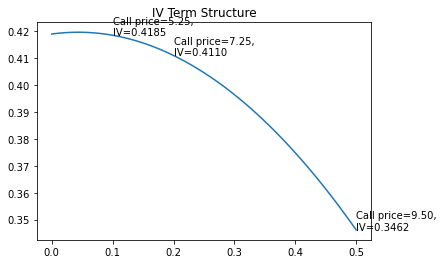

In [14]:
def BScallPrice(sigma,S,rGrow,r,K,T):
    F=S*np.exp(rGrow*T)
    sd = sigma*np.sqrt(T)
    d1 = np.log(F/K)/sd+sd/2
    d2 = d1-sd
    return np.exp(-r*T)*(F*norm.cdf(d1)-K*norm.cdf(d2))

def IVofCall(C,S,rGrow,r,K,T):
    F=S*np.exp(rGrow*T)
    lowerbound = np.max([0,(F-K)*np.exp(-r*T)])
    if C<lowerbound:
        return np.nan
    if C==lowerbound:
        return 0
    if C>=F*np.exp(-r*T):
        return np.nan 
    hi=0.2
    while BScallPrice(hi,S,rGrow,r,K,T)>C:
        hi=hi/2
    while BScallPrice(hi,S,rGrow,r,K,T)<C:
        hi=hi*2
    lo=hi/2
    
    def optim(sigma):
        return BScallPrice(sigma,S,rGrow,r,K,T)-C
    
    impliedVolatility = bisect(optim, lo, hi)     # you fill this in, using bisect or brentq imported from scipy.optimize,
                             # or by writing your own bisection algorithm.
    return impliedVolatility

S = 100
K = 100
r = 0.05
rGrow = 0

Cs = [5.25, 7.25, 9.5]
Ts = [0.1, 0.2, 0.5]
IVs = []
for C, T in zip(Cs, Ts):
    iv = IVofCall(C,S,rGrow,r,K,T)
    IVs.append(iv)
    print(f"At time t={T:.1f}, IV={iv:.4f}")

sigt = interp1d(Ts, IVs, fill_value="extrapolate", kind="quadratic")
time = np.linspace(0, 0.5, 100)
ivt  = sigt(time)

plt.plot(time, ivt)
for C, T, IV in zip(Cs, Ts, IVs): plt.annotate(f"Call price={C:.2f},\nIV={IV:.4f}", (T, IV))
plt.title("IV Term Structure")
plt.show()

#### (c)

Price $C(\sigma(0.4), S=100, ...)$

In [15]:
call = BScallPrice(sigt(0.4),S,rGrow,r,K,0.4)

print(f"The price for a call expiring in 0.4 years is {call:.4f}")

The price for a call expiring in 0.4 years is 9.2485
